In [1]:
# kad torch geometric ne radi triba ga reinstalirat i spustit sympy na = 1.12

In [1]:
import numpy as np
import torch
import healpy as hp
import matplotlib.pyplot as plt
#from torch.utils.data import DataLoader
#from torch_geometric.data import Data
#from torch_geometric.loader import DataLoader as GeoLoader

from qubic.lib.AnalyticalSolution.dataio.generate import generate_sky_projectedsky_pairs
from qubic.lib.AnalyticalSolution.operators.forward_ops import ForwardOps
from qubic.lib.AnalyticalSolution.operators.mono_backprojection import *

from qubic.lib.AnalyticalSolution.graphs import healpix_graph
from qubic.lib.AnalyticalSolution.utils.edges import build_coobs_edges
from qubic.lib.AnalyticalSolution.utils.maps import (
    expand_nest_masked_map, nest2ring_masked_map, full_nest_to_ring, mask_map_unseen
)
from qubic.lib.AnalyticalSolution.utils.losses import edge_mse_1d, edge_mse_iqu
import qubic.lib.AnalyticalSolution.utils as utils
import qubic

[proton:1124679] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
# you have to chose the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Create a QUBIC instrument.

In [3]:
dictfilename = '/home/lkardum/qubic/qubic/lib/AnalyticalSolution/dataio/monofrequency_instrument.dict'
d = qubic.lib.qubicDict()
d.read_from_file(dictfilename)

center = qubic.lib.equ2gal(d['RA_center'], d['DEC_center'])

In [4]:
p = qubic.lib.get_pointing(d)
s = qubic.lib.QubicScene(d)
q = qubic.lib.QubicInstrument(d)
acquisition = qubic.lib.QubicAcquisition(q, p, s, d)
coverage = acquisition.get_coverage()
coverage_nest = hp.reorder(coverage, r2n=True)
P_operator = acquisition.get_projection_operator()

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Info proton: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info proton: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.


In [5]:
seen_indexes_ring = utils.coverage.get_high_coverage_indexes(coverage)
seen_indexes_nest = hp.ring2nest(d['nside'], seen_indexes_ring)

unseen_ring = utils.coverage.get_unseen(coverage)
unseen_nest = hp.reorder(unseen_ring.astype(np.bool_), r2n=True)

## Generation of sky - tod pairs for training the projection. By default, random skies composed of CMB + Dust are generated with a random seed. 

In [10]:
num_samples = 10
sky_list, tod_list, _ = generate_sky_projectedsky_pairs(
    d, q, s, num_samples, acquisition
)

Info proton: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.


Generating sky–projected-sky pairs: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


 As discussed, the Projection is a mixing operator, where its inverse is found with a Neumann expansion $\sum_{m=0}^{\infty} c_m \, T_m(\tilde{L})$ on the Graph.

 Mixing can be presented as a mixture of Diagonal and off-Diagonal elements as in

 $(D + O)^{-1} = D^{-1} \sum_{k=0}^{\infty} c_k (-D^{-1}O)^k = c_1 D^{-1} - c_2 D^{-1}OD^{-1} + c_3 D^{-1}OD^{-1}OD^{-1} - ...$

 The first element in the Neumann series corresponds to the inverse of the mixing coming from the diagonal. Its inverse for the Projection operator is given with $ \frac{P^T}{P \cdot 1}$. Lets visualize this first order correction. 

There is a scale parameter corresponding to the constant multiplying the inverse. This constant is correct only in a one order expansion. It will be refined when the series is actually expanded. 

In [11]:
# There is no need for heavy training, since the first order is given analytically and is just a starting point for the expansion. 
n_epochs = 10
lr = 1e-3

trained_model = train_inverseprojection_firstorderscale(sky_list, tod_list,
                             P_operator, seen_indexes_ring, device, n_epochs = n_epochs, optim_lr=lr)

print("Training completed!")

Epoch 0, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 1, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 2, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 3, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 4, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 5, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 6, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 7, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 8, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Epoch 9, Loss=1.016451e-35  pred_I grad_fn = <SqueezeBackward1 object at 0x742d62db5030>
Training completed!


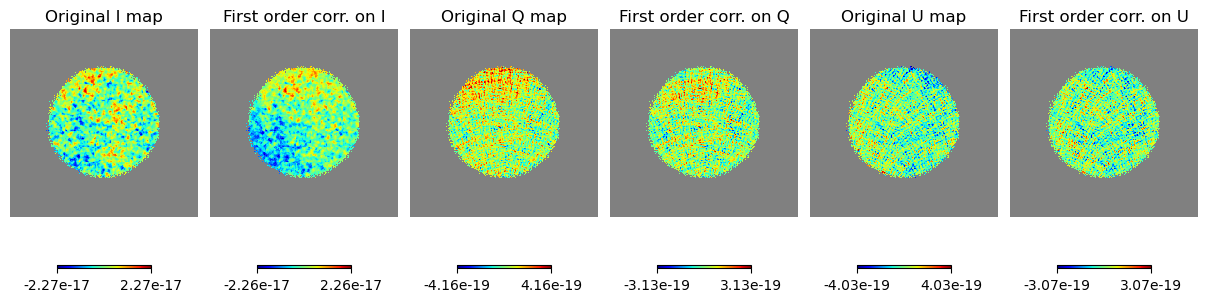

In [14]:
example_no = 2
tod_sample = torch.tensor(tod_list[example_no], dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension

# apply the trained model on the TOD sample
trained_model.eval()
with torch.no_grad():
    sky_I_reconstructed, sky_Q_reconstructed, sky_U_reconstructed = trained_model(tod_sample)[0]
    
reconstructed_I_ring = nest2ring_masked_map(sky_I_reconstructed[:,0], seen_indexes_nest, d['nside'])
reconstructed_Q_ring = nest2ring_masked_map(sky_Q_reconstructed[:,0], seen_indexes_nest, d['nside'])
reconstructed_U_ring = nest2ring_masked_map(sky_U_reconstructed[:,0], seen_indexes_nest, d['nside'])

original_I_ring = sky_list[example_no, :, 0]
original_I_ring[unseen_ring] = hp.UNSEEN

original_Q_ring = sky_list[example_no, :, 1]
original_Q_ring[unseen_ring] = hp.UNSEEN

original_U_ring = sky_list[example_no, :, 2]
original_U_ring[unseen_ring] = hp.UNSEEN

plt.figure(figsize = (12,6))
cmap = 'jet'
hp.gnomview(original_I_ring, rot = center, reso = 20, cmap = cmap, min = -4*np.std(original_I_ring[seen_indexes_ring]), max = 4*np.std(original_I_ring[seen_indexes_ring]),   sub = (1,6,1), title = 'Original I map', notext=True)
hp.gnomview(reconstructed_I_ring, rot = center, reso = 20, cmap = cmap, min = -4*np.std(reconstructed_I_ring[seen_indexes_ring]), max = 4*np.std(reconstructed_I_ring[seen_indexes_ring]), sub = (1,6,2), title = 'First order corr. on I', notext=True)

hp.gnomview(original_Q_ring, rot = center, reso = 20, cmap = cmap, min = -4*np.std(original_Q_ring[seen_indexes_ring]), max = 4*np.std(original_Q_ring[seen_indexes_ring]),  sub = (1,6,3), title = 'Original Q map', notext=True)
hp.gnomview(reconstructed_Q_ring, rot = center, reso = 20, cmap = cmap, min = -4*np.std(reconstructed_Q_ring[seen_indexes_ring]), max = 4*np.std(reconstructed_Q_ring[seen_indexes_ring]), sub = (1,6,4), title = 'First order corr. on Q', notext=True)

hp.gnomview(original_U_ring, rot = center, reso = 20, cmap = cmap, min = -4*np.std(original_U_ring[seen_indexes_ring]), max = 4*np.std(original_U_ring[seen_indexes_ring]), sub = (1,6,5), title = 'Original U map', notext=True)
hp.gnomview(reconstructed_U_ring, rot = center, reso = 20, cmap = cmap, min = -4*np.std(reconstructed_U_ring[seen_indexes_ring]), max = 4*np.std(reconstructed_U_ring[seen_indexes_ring]), sub = (1,6,6), title = 'First order corr. on U', notext=True)

You should get a reconstruction that only roughly resembles the original map in the center. This is the reconstruction made with the information from the diagonal only. The resemblence should also fall off towards the edges. The first order is especially wrong in QUBIC since it has significant off-diagonal effects from secondary lobes.

In [ ]:


seen_indexes_nest = hp.ring2nest(nside, np.asarray(seen_indexes_ring))
model_scale = TrainableInverseProjection(
    op_proj, projection_cov[:, 0], seen_indexes_ring, nside
).to(device)

sky_tensor = torch.tensor(np.array(sky_list), dtype=torch.float32, device=device)  # (N, npix, 3) RING
tod_tensor = torch.tensor(np.array(tod_list), dtype=torch.float32, device=device)  # (N, ndet, nt, 3)

opt_s = torch.optim.Adam([
    {'params': model_scale.lnn_I.scale, 'lr': 1e-1},
    {'params': model_scale.lnn_I.bias , 'lr': 1e-3},
    {'params': model_scale.lnn_Q.scale, 'lr': 1e-1},
    {'params': model_scale.lnn_Q.bias , 'lr': 1e-3},
    {'params': model_scale.lnn_U.scale, 'lr': 1e-1},
    {'params': model_scale.lnn_U.bias , 'lr': 1e-3},
], lr=1e-3)

epochs_scale = 20
for _ in range(epochs_scale):
    opt_s.zero_grad()
    outs = model_scale(tod_tensor[:1])  # tiny fit is enough to fix scale
    (I_s, Q_s, U_s) = outs[0]
    n_pix = 12 * nside**2
    ring2nest = torch.as_tensor(hp.ring2nest(nside, np.arange(n_pix)), dtype=torch.long, device=device)

    sky_ring = sky_tensor[0]                         # (npix,3) RING
    sky_nest = torch.zeros_like(sky_ring)
    sky_nest[ring2nest] = sky_ring                  # full NEST
    I_t = sky_nest[torch.as_tensor(seen_indexes_nest, device=device), 0].unsqueeze(1)
    Q_t = sky_nest[torch.as_tensor(seen_indexes_nest, device=device), 1].unsqueeze(1)
    U_t = sky_nest[torch.as_tensor(seen_indexes_nest, device=device), 2].unsqueeze(1)
    loss_scale = (I_s - I_t).pow(2).mean() + (Q_s - Q_t).pow(2).mean() + (U_s - U_t).pow(2).mean()
    loss_scale.backward()
    opt_s.step()

with torch.no_grad():
    scaled_skies_list = []
    for i in range(tod_tensor.shape[0]):
        I_s, Q_s, U_s = model_scale(tod_tensor[i:i+1])[0]
        scaled_skies_list.append(torch.cat([I_s, Q_s, U_s], dim=-1))  # (N_obs,3)
    scaled_skies_list_torch = torch.stack(scaled_skies_list, dim=0).to(device)  # (N, N_obs, 3)

original_skies_list = []
ring2nest_np = hp.ring2nest(nside, np.arange(12 * nside**2))
for i in range(sky_tensor.shape[0]):
    sky_ring = sky_tensor[i].detach().cpu().numpy()
    I = hp.reorder(sky_ring[:, 0], r2n=True)[seen_indexes_nest]
    Q = hp.reorder(sky_ring[:, 1], r2n=True)[seen_indexes_nest]
    U = hp.reorder(sky_ring[:, 2], r2n=True)[seen_indexes_nest]
    original_skies_list.append(torch.tensor(np.stack([I, Q, U], axis=1), dtype=torch.float32))
original_skies_list_torch = torch.stack(original_skies_list, dim=0).to(device)


G_sky = healpix_graph(nside=nside, nest=True)
G_sky_partial = G_sky.subgraph(seen_indexes_nest)
edge_index = torch.tensor(G_sky_partial.W.nonzero(), dtype=torch.long, device=device)

edge_coobs = build_coobs_edges(op_proj, device=device)


S_I, S_QU = 1e17, 1e18
graphs_IQU = build_graphs_IQU(
    scaled_skies_list_torch, original_skies_list_torch,
    edge_index, tod_list, S_I, S_QU
)
loader = GeoLoader(graphs_IQU, batch_size=1, shuffle=True)

net_IQU = SharedCheb3Head().to(device)

npix = 12 * nside**2
seen_nest_t = torch.as_tensor(seen_indexes_nest, dtype=torch.long, device=device)
seen_ring_t = torch.as_tensor(hp.nest2ring(nside, seen_indexes_nest), dtype=torch.long, device=device)


train_cheb(
    net_IQU, loader,
    edge_geo=edge_index, edge_coobs=edge_coobs,
    S_I=S_I, S_QU=S_QU,
    λ_pix=10., λ_geo=1., λ_coobs=1., λ_phys=10.,
    project_to_tod=op_proj, npix=npix, seen_nest=seen_nest_t, seen_ring=seen_ring_t,
    device=device, epochs=1000, lr=1e-3, step=1000, gamma=0.3, log_every=50
)

train_cheb(
    net_IQU, loader,
    edge_geo=edge_index, edge_coobs=edge_coobs,
    S_I=S_I, S_QU=S_QU,
    λ_pix=1., λ_geo=10., λ_coobs=10., λ_phys=1.,
    project_to_tod=op_proj, npix=npix, seen_nest=seen_nest_t, seen_ring=seen_ring_t,
    device=device, epochs=1000, lr=1e-3, step=1000, gamma=0.3, log_every=50
)

train_cheb(
    net_IQU, loader,
    edge_geo=edge_index, edge_coobs=edge_coobs,
    S_I=S_I, S_QU=S_QU,
    λ_pix=10., λ_geo=10., λ_coobs=10., λ_phys=10.,
    project_to_tod=op_proj, npix=npix, seen_nest=seen_nest_t, seen_ring=seen_ring_t,
    device=device, epochs=1000, lr=1e-3, step=1000, gamma=0.3, log_every=50
)

#
example_no = 6
net_IQU.eval()
with torch.no_grad():
    g = graphs_IQU[example_no]
    pred_scaled = net_IQU(g.x.to(device), edge_index).cpu()
    true_scaled = (g.x + g.y).cpu()

pred_phys = np.stack([ pred_scaled[:,0]/S_I, pred_scaled[:,1]/S_QU, pred_scaled[:,2]/S_QU ], axis=1)
true_phys = np.stack([ true_scaled[:,0]/S_I, true_scaled[:,1]/S_QU, true_scaled[:,2]/S_QU ], axis=1)

recon_I = expand_nest_masked_map(pred_phys[:,0], seen_indexes_nest, nside)
recon_Q = expand_nest_masked_map(pred_phys[:,1], seen_indexes_nest, nside)
recon_U = expand_nest_masked_map(pred_phys[:,2], seen_indexes_nest, nside)

orig_I = sky_list[example_no, :, 0].copy(); orig_I[unseen] = hp.UNSEEN
orig_Q = sky_list[example_no, :, 1].copy(); orig_Q[unseen] = hp.UNSEEN
orig_U = sky_list[example_no, :, 2].copy(); orig_U[unseen] = hp.UNSEEN

diff_I = orig_I - nest2ring_masked_map(pred_phys[:,0], seen_indexes_nest, nside)
diff_Q = orig_Q - nest2ring_masked_map(pred_phys[:,1], seen_indexes_nest, nside)
diff_U = orig_U - nest2ring_masked_map(pred_phys[:,2], seen_indexes_nest, nside)
diff_I[unseen] = hp.UNSEEN; diff_Q[unseen] = hp.UNSEEN; diff_U[unseen] = hp.UNSEEN

plt.figure(figsize=(12,8))
hp.gnomview(recon_I, rot=center, reso=20, sub=(3,4,1),  nest=True, title='Corrected I', cmap='jet', notext=True)
hp.gnomview(orig_I,  rot=center, reso=20, sub=(3,4,2),  title='Original I', cmap='jet', notext=True)
hp.gnomview(diff_I,  rot=center, reso=20, sub=(3,4,3),  title='Diff I', cmap='jet', notext=True)

hp.gnomview(recon_Q, rot=center, reso=20, sub=(3,4,5),  nest=True, title='Corrected Q', cmap='jet', notext=True)
hp.gnomview(orig_Q,  rot=center, reso=20, sub=(3,4,6),  title='Original Q', cmap='jet', notext=True)
hp.gnomview(diff_Q,  rot=center, reso=20, sub=(3,4,7),  title='Diff Q', cmap='jet', notext=True)

hp.gnomview(recon_U, rot=center, reso=20, sub=(3,4,9),  nest=True, title='Corrected U', cmap='jet', notext=True)
hp.gnomview(orig_U,  rot=center, reso=20, sub=(3,4,10), title='Original U', cmap='jet', notext=True)
hp.gnomview(diff_U,  rot=center, reso=20, sub=(3,4,11), title='Diff U', cmap='jet', notext=True)
plt.show()


NameError: name 'nside' is not defined